#### 該文件包含1,338個案例，即目前已經登記過的保險計劃受益者、病人特點和計劃計入的總醫療費用特徵:

* age:表示主要受益者年齡
* sex:性別
* bmi:身體質量指數,理想BMI在18.5~24.9之間
* children:表示保險計劃中所包括的孩子/受撫養者的數量
* smoker:表示被保險人是否經常吸煙
* region:受益者在美國的居住地-東北(northeast), 東南(sotheast), 西南(southwest)和東北(northwest)
* charges:醫療費用

#### 目的:檢測與醫療費用相關之變量，找出在醫療費用上具高風險的人

In [142]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [144]:
# 讀取 .csv 建立 dataframe
df = pd.read_csv('insurance.csv')

In [145]:
# 查看資料型態
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [146]:
# 簡單查看資料樣本
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [171]:
# 列出欄位方便修改
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'is_east', 'is_north',
       'charges'],
      dtype='object')

In [147]:
# 將資訊數值化

df['sex'] = df['sex'].apply({'male':0, 'female':1}.get)
df['smoker'] = df['smoker'].apply({'no':0, 'yes':1}.get)

# region 變更為東西、南北
df['is_east'] = df['region'].apply(lambda x: 1 if 'east' in x else 0)
df['is_north'] = df['region'].apply(lambda x: 1 if 'north' in x else 0)

# 刪除原本的region
df = df.drop('region', axis=1)

# 修改順序，把 Y 放最後方便查看
charges = df.pop('charges')
df['charges'] = charges

# 檢查修改後資料型態
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int64  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   is_east   1338 non-null   int64  
 6   is_north  1338 non-null   int64  
 7   charges   1338 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 83.8 KB


In [148]:
# 簡單查看修改後資料樣本
df.head()

,age,sex,bmi,children,smoker,is_east,is_north,charges
0,19,1,27.900,0,1,0,0,16884.92400
1,18,0,33.770,1,0,1,0,1725.55230
2,28,0,33.000,3,0,1,0,4449.46200
3,33,0,22.705,0,0,0,1,21984.47061
4,32,0,28.880,0,0,0,1,3866.85520


In [150]:
# 將部分欄位數值標準化
from sklearn import preprocessing
minmax = preprocessing.MinMaxScaler()
x_minmax = minmax.fit_transform(df[['age', 'bmi', 'children']])

In [151]:
# 建立新的 dataframe
x_minmax= pd.DataFrame(x_minmax, columns=['age', 'bmi', 'children'])

In [152]:
# 將其他未標準化的欄位也放入新的 dataframe
res_minmax = pd.concat([x_minmax.reset_index(drop=True), df[['sex', 'smoker', 'is_east','is_north']]], axis=1)

res_minmax

,age,bmi,children,sex,smoker,is_east,is_north
0,0.021739,0.321227,0.0,1,1,0,0
1,0.000000,0.479150,0.2,0,0,1,0
2,0.217391,0.458434,0.6,0,0,1,0
3,0.326087,0.181464,0.0,0,0,0,1
4,0.304348,0.347592,0.0,0,0,0,1
...,...,...,...,...,...,...,...
1333,0.695652,0.403820,0.6,0,0,0,1
1334,0.000000,0.429379,0.0,1,0,1,1
1335,0.000000,0.562012,0.0,1,0,1,0
1336,0.065217,0.264730,0.0,1,0,0,0


In [153]:
X = df.iloc[:, 0:7].values # 選取前 7 列作為特徵
y = df.iloc[:, 7].values.reshape(-1,1) # 第 8 列當作目標變量

# 數據分割，訓練與測試
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)

# 顯示樣本數、特徵數
print(f"Shape of X_train:{X_train.shape}")
print(f"Shape of X_test:{X_test.shape}")
print(f"Shape of y_train:{y_train.shape}")
print(f"Shape of y_test{y_test.shape}")

Shape of X_train:(936, 7)
Shape of X_test:(402, 7)
Shape of y_train:(936, 1)
Shape of y_test(402, 1)


In [154]:
# 查看有無 null
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
is_east     0
is_north    0
charges     0
dtype: int64

In [155]:
# 確認基礎統計量
df.describe()

,age,sex,bmi,children,smoker,is_east,is_north,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.494768,30.663397,1.094918,0.204783,0.514200,0.485052,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,0.499985,0.499963,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,0.000000,0.000000,4740.287150
50%,39.000000,0.000000,30.400000,1.000000,0.000000,1.000000,0.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,1.000000,1.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,1.000000,1.000000,63770.428010


In [180]:
# 查看是否有異常值
df.sort_values(by=['charges'], ascending=False)

,age,sex,bmi,children,smoker,is_east,is_north,charges
543,54,1,47.410,0,1,1,0,63770.42801
1300,45,0,30.360,0,1,1,0,62592.87309
1230,52,0,34.485,3,1,0,1,60021.39897
577,31,1,38.095,1,1,1,1,58571.07448
819,33,1,35.530,0,1,0,1,55135.40209
...,...,...,...,...,...,...,...,...
22,18,0,34.100,0,0,1,0,1137.01100
663,18,0,33.660,0,0,1,0,1136.39940
1244,18,0,33.330,0,0,1,0,1135.94070
808,18,0,30.140,0,0,1,0,1131.50660


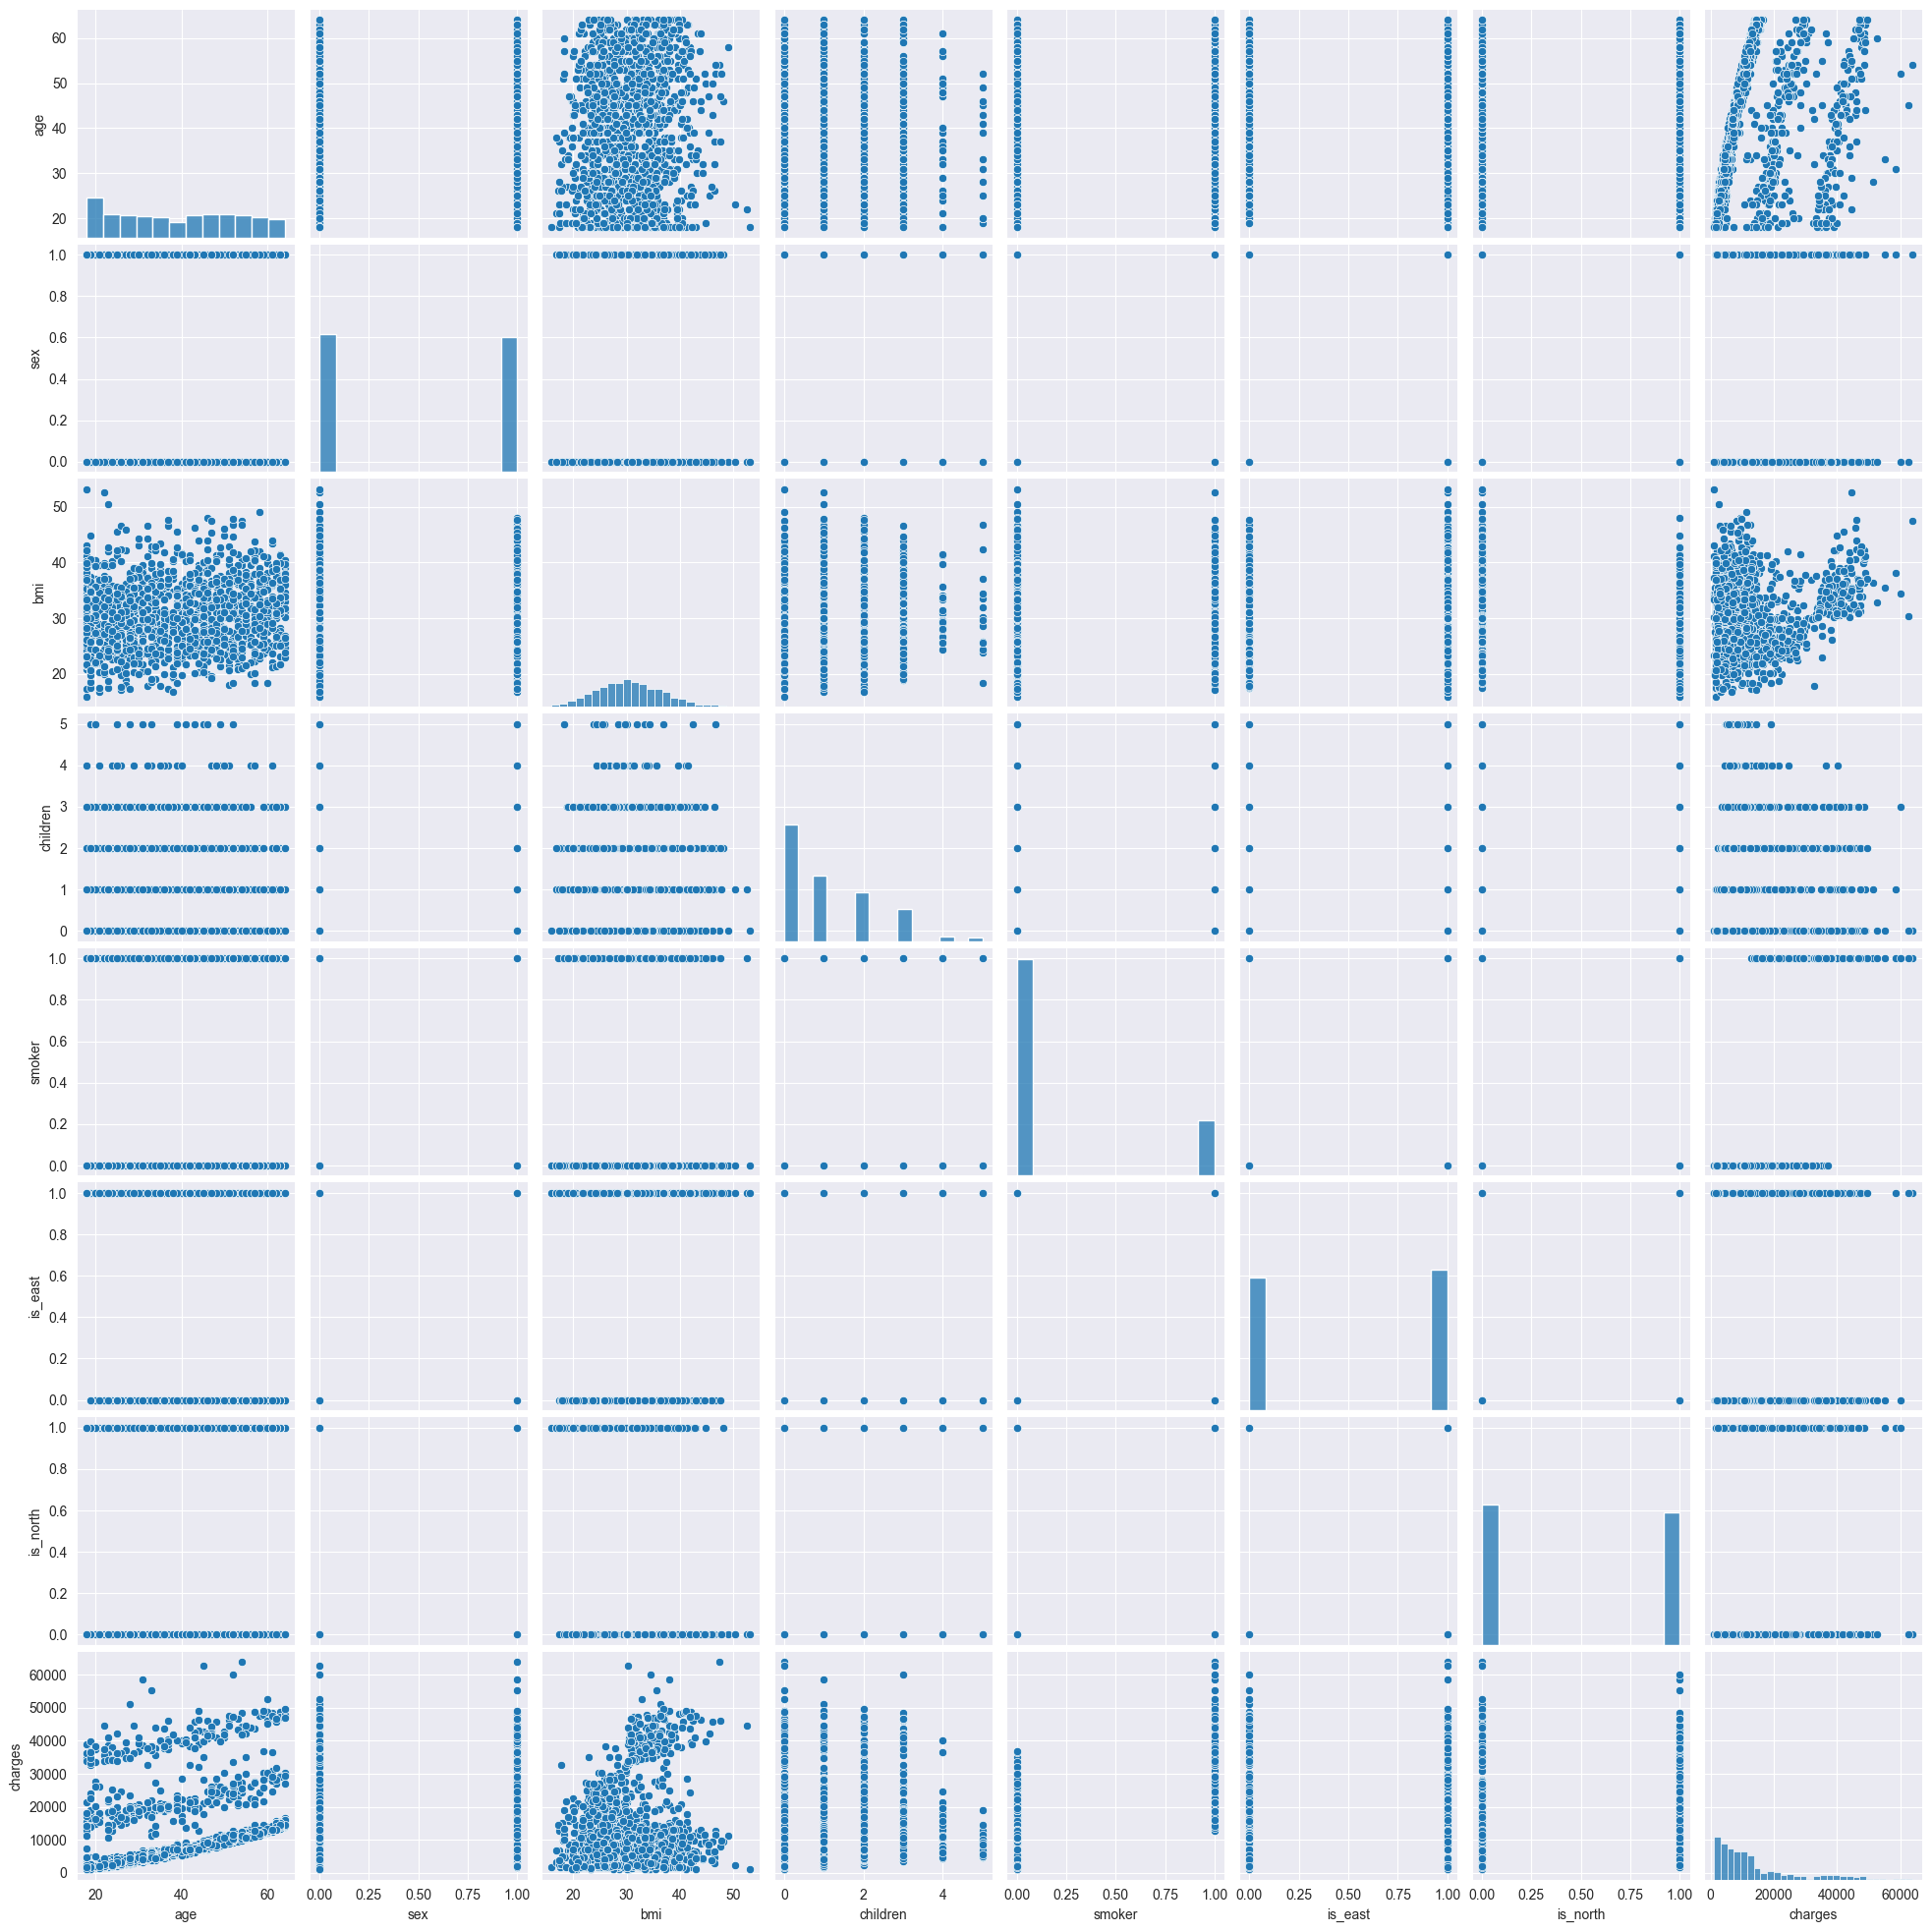

In [172]:
# 觀察各 X 與 Y 的關係
sns.pairplot(df[['age', 'sex', 'bmi', 'children', 'smoker', 'is_east','is_north', 'charges']])

<Axes: >

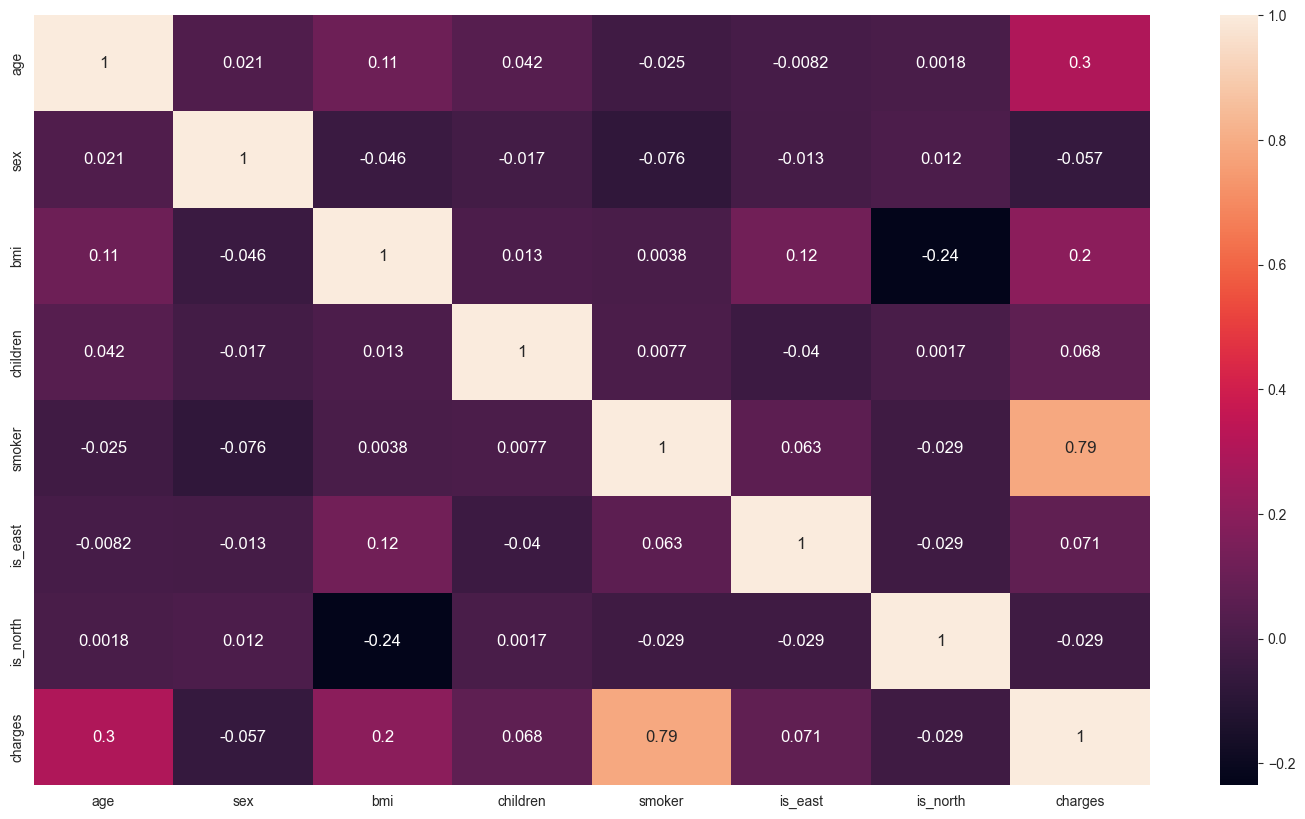

In [159]:
# 觀察變數間的關係，注意有無共線性
corrmat = df.corr()
fig, ax = plt.subplots(figsize = (18, 10))
sns.heatmap(corrmat, annot = True, annot_kws={'size': 12})

# 可看出 X 相互並無共線性， age, bmi, smoker 皆與 Y 為正相關，其中 smoker 為高度正相關

In [176]:
# 嘗試 Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 創建線性回歸模型並擬合
regressor_linear = LinearRegression() 
regressor_linear.fit(X_train, y_train)

# R2 score
y_pred_linear_train = regressor_linear.predict(X_train)
r2_score_linear_train = r2_score(y_train, y_pred_linear_train)
y_pred_linear_test = regressor_linear.predict(X_test)
r2_score_linear_test = r2_score(y_test, y_pred_linear_test)

# RMSE
rmse_train = (np.sqrt(mean_squared_error(y_train, y_pred_linear_train)))
rmse_test = (np.sqrt(mean_squared_error(y_test, y_pred_linear_test)))

print('R2_score (train): ', r2_score_linear_train)
print('R2_score (test): ', r2_score_linear_test)
print("RMSE: ", rmse_train)
print("RMSE: ", rmse_test)

R2_score (train):  0.7575613897832577
R2_score (test):  0.7310381989312021
RMSE:  5941.22523575346
RMSE:  6323.9041309676795


In [163]:
# 查看變數是否顯著
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
est = sm.OLS(y, X2).fit()
print(est.summary())

# 可看出 sex , is_east 的P值明顯過高，為不顯著
# is_north 的P值也達到0.016，P值若設定較小，也是不顯著

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     572.6
Date:                Tue, 14 Jan 2025   Prob (F-statistic):               0.00
Time:                        09:57:23   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1330   BIC:                         2.715e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.308e+04   1030.214    -12.693      0.0

In [164]:
# 方便對照上面變數
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int64  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   is_east   1338 non-null   int64  
 6   is_north  1338 non-null   int64  
 7   charges   1338 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 83.8 KB


In [179]:
# 嘗試 Polynomial
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree = 2) # 2次方
X_poly = poly_reg.fit_transform(X_train) # 轉換特徵 (增加次方項、交互項)

# 創建線性回歸模型並擬合
regressor_poly2 = LinearRegression()
regressor_poly2.fit(X_poly, y_train)

# R2 score
y_pred_poly2_train = regressor_poly2.predict(poly_reg.fit_transform(X_train))
r2_score_poly2_train = r2_score(y_train, y_pred_poly2_train)
y_pred_poly2_test = regressor_poly2.predict(poly_reg.fit_transform(X_test))
r2_score_poly2_test = r2_score(y_test, y_pred_poly2_test)

# RMSE
rmse_train = (np.sqrt(mean_squared_error(y_train, y_pred_poly2_train)))
rmse_test = (np.sqrt(mean_squared_error(y_test, y_pred_poly2_test)))

print('R2_score (train): ', r2_score_poly2_train)
print('R2_score (test): ', r2_score_poly2_test)
print("RMSE: ", rmse_train)
print("RMSE: ", rmse_test)

# 可看出 Polynomial 的 R2 比 Liner 高約0.1，穩定度兩者差異不大

R2_score (train):  0.8540077144630556
R2_score (test):  0.8266086101497132
RMSE:  4610.41562042872
RMSE:  5077.54451113936


In [174]:
# 嘗試 Lasso regression
lasso = Lasso(alpha = 0.5) # 設定懲罰度
lasso.fit(X_train,y_train) # 數據擬合至 lasso

# 預測 & R2
y_pred_lasso_train = lasso.predict(X_train)
r2_score_lasso_train = lasso.score(X_train, y_train)
y_pred_lasso_test = lasso.predict(X_test)
r2_score_lasso_test = lasso.score(X_test, y_test)

# RMSE
rmse_lasso_train = (np.sqrt(mean_squared_error(y_train, y_pred_lasso_train)))
rmse_lasso_test = (np.sqrt(mean_squared_error(y_test, y_pred_lasso_test)))

print('R2_score (train): ', r2_score_lasso_train)
print('R2_score (test): ', r2_score_lasso_test)
print("RMSE: ", rmse_lasso_train)
print("RMSE: ", rmse_lasso_test)
print()
print("coef：")
for i, j in zip(df.columns, lasso.coef_):
    print(i, j)

# R2、穩定度與 Liner 差不多，且沒有任何特徵被排除 (變數係數為 0)

R2_score (train):  0.7575613527539182
R2_score (test):  0.7310655113364896
RMSE:  5941.225689475822
RMSE:  6323.583034408599

coef：
age 260.760208855606
sex 13.9589026252034
bmi 319.9703735153742
children 444.2471763075152
smoker 24445.053321851716
is_east -15.634701045753035
is_north 1400.2113750200085


In [175]:
# 嘗試 Ridge regression
ridgeReg = Ridge(alpha=0.5) # 設定懲罰度
ridgeReg.fit(X_train, y_train) # 數據擬合至 ridge

# 預測 & R2
y_pred_ridge_train = ridgeReg.predict(X_train)
r2_score_ridge_train = ridgeReg.score(X_train, y_train)
y_pred_ridge_test = ridgeReg.predict(X_test)
r2_score_ridge_test = ridgeReg.score(X_test, y_test)

# RMSE
rmse_ridge_train = (np.sqrt(mean_squared_error(y_train, y_pred_ridge_train)))
rmse_ridge_test = (np.sqrt(mean_squared_error(y_test, y_pred_ridge_test)))

print("R2_score (train): ",r2_score_ridge_train)
print("R2_score (test):", r2_score_ridge_test)
print("train_RMSE: ", rmse_ridge_train)
print("test_RMSE: ", rmse_ridge_test)
print()
print("coef：")
for i, j in zip(df.columns, ridgeReg.coef_):
    print(i, j)

# R2、穩定度都跟 Liner、Lasso差不多，係數也與 Lasso 的大同小異，可能代表特徵對預測都是有貢獻的。同時表達正則化的效果不明顯，可以考慮使用簡單的線性回歸即可。

R2_score (train):  0.7575538031823946
R2_score (test): 0.7314258758110759
train_RMSE:  5941.318194032351
test_RMSE:  6319.344904556365

coef：
age 260.6860506893553
sex 11.777763533947317
bmi 320.0554978105725
children 445.13471974053783
smoker 24363.98946713398
is_east -14.603747831865718
is_north 1398.085609770111
